In [1]:
! pip install numpy==1.26.4
! pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import dice

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
image_folder = 'a0-2025-medical-image-segmentation/Dataset/Train/Image/'
mask_folder = 'a0-2025-medical-image-segmentation/Dataset/Train/Mask/'

In [5]:
# Standard normalization values used for ImageNet models
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

input_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])
target_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
images = []
for filename in os.listdir(image_folder):
    img_path = os.path.join(image_folder, filename)
    if os.path.isfile(img_path):
        image = Image.open(img_path).convert('RGB')
        image = input_transform(image)
        images.append(image)
image_tensors = torch.stack(images)

In [7]:
masks = []
for filename in os.listdir(mask_folder):
    img_path = os.path.join(mask_folder, filename)
    if os.path.isfile(img_path):
        mask = Image.open(img_path)
        mask = target_transform(mask)
        masks.append(mask)
mask_tensors = torch.stack(masks)

In [8]:
train_set = torch.utils.data.TensorDataset(image_tensors, mask_tensors)

In [9]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

In [10]:
class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()
        vgg = torchvision.models.vgg16(pretrained=True)
        features = list(vgg.features.children())

        self.features = nn.Sequential(*features)
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, padding=16, bias=False)

    def forward(self, x):
        x_size = x.size()
        x = self.features(x)
        x = self.score_fr(x)
        x = self.upscore(x)
        x = x[:, :, :x_size[2], :x_size[3]].contiguous()  # crop to match input size
        return x

In [11]:
model = FCN(num_classes=2).to(device)

c:\Users\70p6229\computer_vision\examples\pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\70p6229\computer_vision\examples\pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [13]:
epochs = 50

In [14]:
model.train()
for epoch in range(epochs):
    losses_epoch = 0
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.squeeze(1).long().to(device)

        outputs = model(imgs)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_epoch += loss.item()

    print(f"Epoch {epoch+1}, Loss: {losses_epoch:.4f}")

Epoch 1, Loss: 137.8651
Epoch 2, Loss: 115.4745
Epoch 3, Loss: 91.2615
Epoch 4, Loss: 67.3579
Epoch 5, Loss: 63.9391
Epoch 6, Loss: 58.3758
Epoch 7, Loss: 86.8920
Epoch 8, Loss: 100.7031
Epoch 9, Loss: 62.8225
Epoch 10, Loss: 56.2784
Epoch 11, Loss: 48.5294
Epoch 12, Loss: 50.2406
Epoch 13, Loss: 48.2867
Epoch 14, Loss: 43.4889
Epoch 15, Loss: 42.1312
Epoch 16, Loss: 42.8352
Epoch 17, Loss: 37.8943
Epoch 18, Loss: 36.7799
Epoch 19, Loss: 34.7387
Epoch 20, Loss: 36.5512
Epoch 21, Loss: 37.4047
Epoch 22, Loss: 32.9066
Epoch 23, Loss: 31.0028
Epoch 24, Loss: 31.3367
Epoch 25, Loss: 29.9594
Epoch 26, Loss: 31.2400
Epoch 27, Loss: 27.0177
Epoch 28, Loss: 25.6631
Epoch 29, Loss: 26.0282
Epoch 30, Loss: 24.6685
Epoch 31, Loss: 25.9434
Epoch 32, Loss: 24.9265
Epoch 33, Loss: 29.0238
Epoch 34, Loss: 33.8311
Epoch 35, Loss: 22.8171
Epoch 36, Loss: 20.0454
Epoch 37, Loss: 17.8893
Epoch 38, Loss: 16.9682
Epoch 39, Loss: 21.4119
Epoch 40, Loss: 19.6596
Epoch 41, Loss: 16.7086
Epoch 42, Loss: 17.058

In [15]:
model.eval()

FCN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
preds = torch.zeros(1, 224, 224)
truths = torch.zeros(1, 1, 224, 224)
with torch.no_grad():
    for imgs, masks in train_loader:
        preds = torch.cat((preds, torch.argmax(model(imgs.to(device)).cpu(), dim=1)), 0)
        truths = torch.cat((truths, masks), 0)

preds = preds[1:]
truths = truths[1:].squeeze()

In [17]:
def dice_coef(y_true, y_pred):
    num_images = len(y_true)
    dice_avg = 0
    for i in range(num_images):
        y_true_f = y_true[i].flatten()
        y_pred_f = y_pred[i].flatten()
        # intersection = np.sum(y_true_f * y_pred_f)
        # dice_avg += (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
        dice_avg += (1 - dice(y_true_f, y_pred_f))
    return dice_avg / num_images

In [18]:
dice_coef(truths.numpy(), preds.numpy())

0.9405825324079634

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7870152..1.6324171].


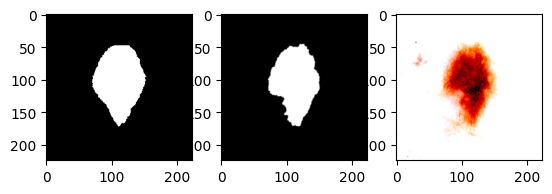

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.9428324].


0.9484878580486349


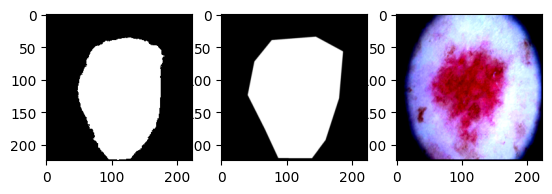

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4384314..1.1186745].


0.9454513927382006


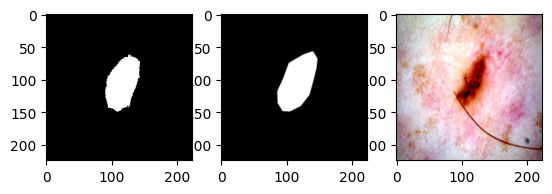

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6505601..1.6465361].


0.9006209261321778


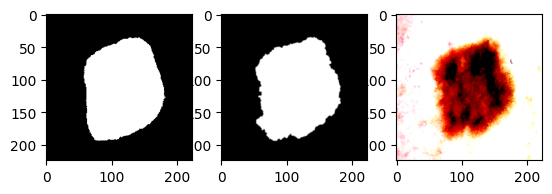

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.792717..2.64].


0.9668834263070781


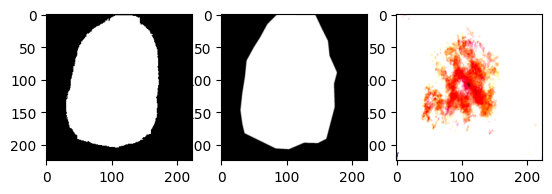

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7906162..2.11191].


0.9649119047445074


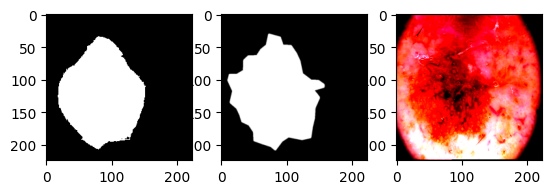

0.9480850595922834


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6650109..1.9602616].


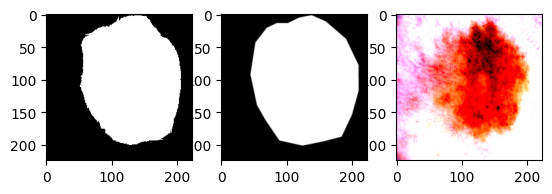

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6475817..2.3611329].


0.9566994375664031


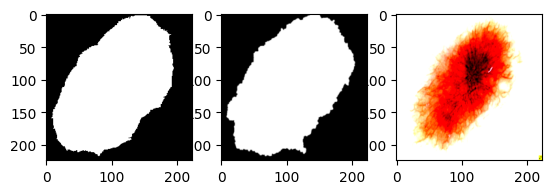

0.9589742379817513


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.229281..2.465708].


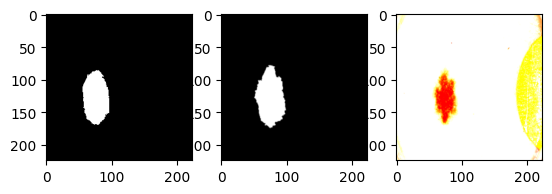

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.7694151].


0.911879423083331


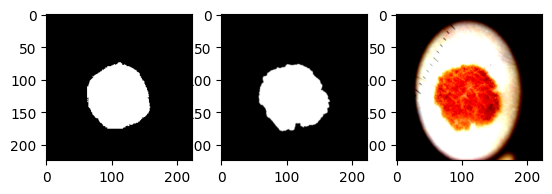

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1247058..1.0365143].


0.9396328724501131


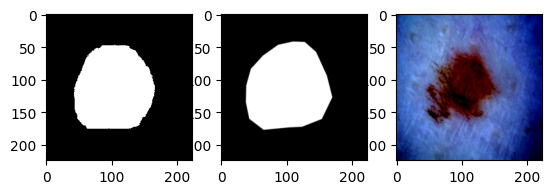

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79355115..1.3070468].


0.9490007436160389


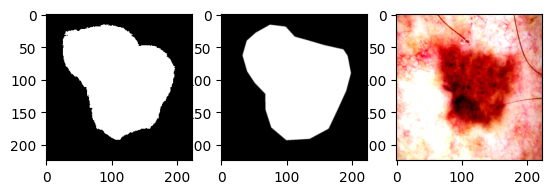

0.9447879037131867


In [19]:
with torch.no_grad():
    for i, (imgs, masks) in enumerate(train_loader):
        imgs = imgs.to(device)
        outputs = model(imgs)

        for j in range(min(4, imgs.size(0))):
            plt.subplot(131)
            pred_mask = torch.argmax(outputs[j], dim=0).cpu().numpy()
            plt.imshow(pred_mask, cmap='gray')
            plt.subplot(132)
            truth_mask = masks.squeeze().cpu().numpy()[j]
            plt.imshow(truth_mask, cmap='gray')
            plt.subplot(133)
            plt.imshow(imgs.permute(0, 2, 3, 1).cpu().numpy()[j])
            plt.show()
            print(1 - dice(truth_mask.flatten(), pred_mask.flatten()))

        if i == 2:
            break

In [20]:
dice_sum = 0
i = 0

for filename in os.listdir(image_folder):
    img_path = os.path.join(image_folder, filename)
    image = Image.open(img_path).convert('RGB')
    orig_width, orig_height = image.size

    image = transforms.Resize((224, 224))(image)
    image = transforms.ToTensor()(image)
    image = transforms.Normalize(mean=imagenet_mean, std=imagenet_std)(image)

    with torch.no_grad():
        pred_mask_tensor = torch.argmax(model(image.unsqueeze(0).to(device)).squeeze(), dim=0).cpu().to(torch.uint8)

    pred_mask = transforms.functional.to_pil_image(pred_mask_tensor)
    pred_mask = np.array(transforms.Resize((orig_height, orig_width))(pred_mask))

    mask_path = os.path.join(mask_folder, re.sub(r"jpg", "png", filename))
    truth_mask = np.array(Image.open(mask_path))
    truth_mask = np.where(truth_mask == 255, 1, 0)

    dice_sum += (1 - dice(truth_mask.flatten(), pred_mask.flatten()))
    i += 1

dice_avg = dice_sum / i

In [21]:
dice_avg

0.9408114921290587

test data

In [22]:
def mask_to_rle(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))

In [23]:
test_image_folder = 'a0-2025-medical-image-segmentation/Dataset/Test/Image/'

df_submission = pd.DataFrame(columns=['ID', 'MASK'])

for filename in os.listdir(test_image_folder):
    img_path = os.path.join(test_image_folder, filename)
    image = Image.open(img_path).convert('RGB')
    orig_width, orig_height = image.size

    image = transforms.Resize((224, 224))(image)
    image = transforms.ToTensor()(image)
    image = transforms.Normalize(mean=imagenet_mean, std=imagenet_std)(image)

    with torch.no_grad():
        pred_mask_tensor = torch.argmax(model(image.unsqueeze(0).to(device)).squeeze(), dim=0).cpu().to(torch.uint8)

    pred_mask_image = transforms.functional.to_pil_image(pred_mask_tensor)
    pred_mask_image = np.array(transforms.Resize((orig_height, orig_width))(pred_mask_image))
    pred_mask_rle = mask_to_rle(pred_mask_image)

    id = filename.split('.')[0]
    df_submission = pd.concat([df_submission, pd.DataFrame([[id, pred_mask_rle]], columns=df_submission.columns)], ignore_index=True)

df_submission.to_csv('submission.csv', index=False)

validation run

In [24]:
train_ds, val_ds = torch.utils.data.random_split(train_set, [0.8, 0.2])

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4)

model = FCN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
    model.train()
    losses_epoch = 0
    for imgs, masks in train_dl:
        imgs = imgs.to(device)
        masks = masks.squeeze(1).long().to(device)
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses_epoch += loss.item()
    print(f"Epoch {epoch+1}, Loss: {losses_epoch:.4f}")
    model.eval()
    with torch.no_grad():
        valid_loss = sum(criterion(model(X.to(device)), y.squeeze(1).long().to(device)).item() for X, y in val_dl)
    print('epoch {}, validation loss {}'.format(epoch+1, valid_loss))

model.eval()

preds = torch.zeros(1, 224, 224)
truths = torch.zeros(1, 1, 224, 224)
with torch.no_grad():
    for imgs, masks in val_dl:
        preds = torch.cat((preds, torch.argmax(model(imgs.to(device)).cpu(), dim=1)), 0)
        truths = torch.cat((truths, masks), 0)
preds = preds[1:]
truths = truths[1:].squeeze()

dice_coef(truths.numpy(), preds.numpy())

c:\Users\70p6229\computer_vision\examples\pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\70p6229\computer_vision\examples\pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 112.2142
epoch 1, validation loss 23.906876534223557
Epoch 2, Loss: 139.5482
epoch 2, validation loss 27.49370864033699
Epoch 3, Loss: 103.0878
epoch 3, validation loss 20.045747011899948
Epoch 4, Loss: 77.7844
epoch 4, validation loss 19.368228867650032
Epoch 5, Loss: 59.6908
epoch 5, validation loss 16.617448270320892
Epoch 6, Loss: 50.3961
epoch 6, validation loss 12.432614207267761
Epoch 7, Loss: 45.7782
epoch 7, validation loss 12.255871504545212
Epoch 8, Loss: 42.8838
epoch 8, validation loss 10.663125585764647
Epoch 9, Loss: 36.5747
epoch 9, validation loss 10.203163355588913
Epoch 10, Loss: 34.3822
epoch 10, validation loss 9.869308765977621
Epoch 11, Loss: 32.2485
epoch 11, validation loss 9.026626907289028
Epoch 12, Loss: 28.9403
epoch 12, validation loss 8.561994194984436
Epoch 13, Loss: 28.6712
epoch 13, validation loss 9.524796307086945
Epoch 14, Loss: 29.1618
epoch 14, validation loss 8.602167449891567
Epoch 15, Loss: 27.7564
epoch 15, validation loss 8.559

0.8836128599635737